#### Filtering US dataframe into WY - census tracts

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# imoporting SVI data for the entire US(county level) 
us_svi = gpd.read_file('../data/processed data/SVI - census tract level/SVI 2018 with HepVu census tracts/SVI2018_US_census_with_opioid_indicators.shp')

In [5]:
# include only the Wyoming(census level data )
filtered_svi_df = us_svi[us_svi['ST_ABBR'].isin(['WY'])]

In [6]:
# reset index
filtered_svi_df.reset_index(drop=True, inplace=True)

In [7]:
filtered_svi_df

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Shape_Leng,Shape_Area,NOD_Rate,geometry
0,56,WYOMING,WY,56021,Laramie,56021980801,"Census Tract 9808.01, Laramie County, Wyoming",1.385724,0,12,...,-999,0,12,-999.0,-999.0,1066,0.117377,0.000386,13.8,"POLYGON ((-104.82867 41.16409, -104.81932 41.1..."
1,56,WYOMING,WY,56001,Albany,56001963000,"Census Tract 9630, Albany County, Wyoming",1.389807,2351,216,...,0,414,160,17.6,6.6,2406,0.117368,0.000392,11.8,"POLYGON ((-105.59813 41.34602, -105.59417 41.3..."
2,56,WYOMING,WY,56001,Albany,56001963100,"Census Tract 9631, Albany County, Wyoming",2.703146,8046,526,...,0,229,142,2.8,1.8,4141,0.129419,0.000752,11.8,"POLYGON ((-105.58395 41.32623, -105.58236 41.3..."
3,56,WYOMING,WY,56001,Albany,56001963400,"Census Tract 9634, Albany County, Wyoming",0.511864,3402,336,...,1,225,102,6.7,2.8,3056,0.066782,0.000142,11.8,"POLYGON ((-105.59620 41.31499, -105.59189 41.3..."
4,56,WYOMING,WY,56001,Albany,56001963600,"Census Tract 9636, Albany County, Wyoming",0.780576,4302,358,...,0,190,82,4.5,2.0,3252,0.088367,0.000215,11.8,"POLYGON ((-105.59401 41.30730, -105.59392 41.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,56,WYOMING,WY,56013,Fremont,56013940300,"Census Tract 9403, Fremont County, Wyoming",15.215910,5316,390,...,2,1009,343,20.3,6.7,4323,0.406148,0.004467,21.8,"POLYGON ((-108.39944 43.01556, -108.39776 43.0..."
128,56,WYOMING,WY,56021,Laramie,56021000700,"Census Tract 7, Laramie County, Wyoming",2.112035,3981,355,...,3,437,182,12.1,4.9,16700,0.148859,0.000589,13.8,"POLYGON ((-104.85112 41.11895, -104.85043 41.1..."
129,56,WYOMING,WY,56025,Natrona,56025001200,"Census Tract 12, Natrona County, Wyoming",4.999851,2296,267,...,2,452,139,22.2,6.5,6871,0.205310,0.001441,18.3,"POLYGON ((-106.41731 42.85616, -106.41751 42.8..."
130,56,WYOMING,WY,56037,Sweetwater,56037970903,"Census Tract 9709.03, Sweetwater County, Wyoming",4.740506,3074,423,...,2,461,200,15.0,5.8,6019,0.235407,0.001326,18.9,"POLYGON ((-109.31046 41.55751, -109.28884 41.5..."


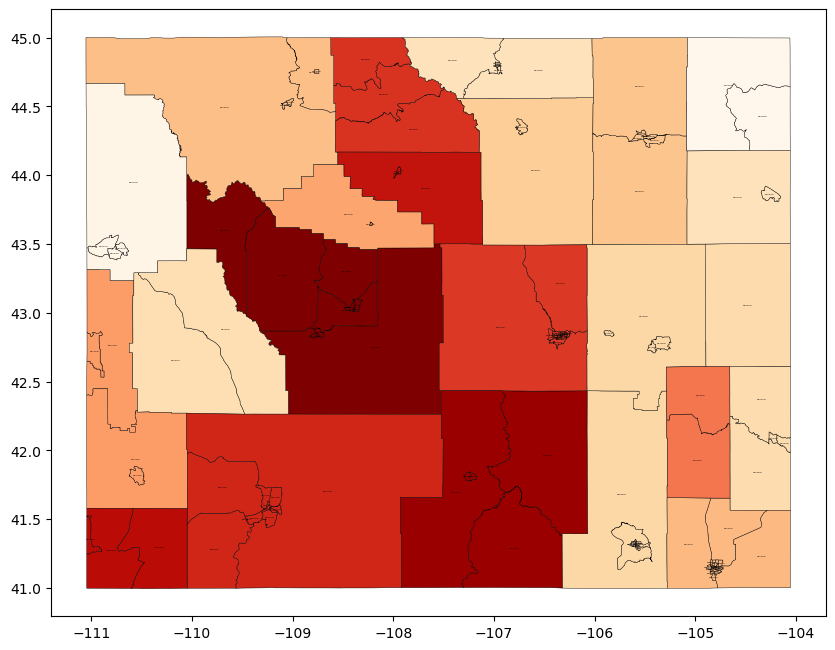

In [8]:
# Plot the data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
ax = filtered_svi_df.plot(figsize=(10, 10), column="NOD_Rate", legend=False, cmap='OrRd', edgecolor='black',linewidth=0.3)

for idx, row in filtered_svi_df.iterrows():
    centroid = row.geometry.centroid
    county_name = row.FIPS
    ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=0.5)

# Display the plot
plt.show()

#### Saving dataframe to a shapefile

In [10]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(filtered_svi_df, geometry='geometry')

In [11]:

# Save the GeoDataFrame to a Shapefile
gdf.to_file("./data/processed data/SVI with HepVu census tracts/SVI2018 WY census tracts with death rate HepVu/SVI2018_WY_census_tracts_with_death_rate_HepVu.shp", driver='ESRI Shapefile')